### The necessary imports

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from operator import itemgetter

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, chi2, f_classif
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


## Loading the data

In [10]:
# The dataset
mvp_votings = pd.read_csv('mvps.csv')
#mvp_votings = mvp_votings[mvp_votings['in_mvp_list'] == 1]


## the clearning data step
mvp_votings.drop('Unnamed: 0', 1, inplace= True)
mvp_votings = mvp_votings.fillna(0)

## split into train and test
test_data = mvp_votings[mvp_votings['Year'] == 2021]
mvp_votings = mvp_votings[mvp_votings['Year'] != 2021]


class_mvp = mvp_votings
mvp_idx = class_mvp.groupby(['Year'])['Share'].transform(max)==class_mvp['Share']
# Adding a new column to specify the classes of the MVP
class_mvp['MVP'] = 0
class_mvp.loc[mvp_idx, 'MVP'] = 1

to_drop = ['Rank','Player','Age','Tm','First','Share','PTS']
class_mvp.drop(to_drop, axis=1,inplace=True)

y = class_mvp['MVP'].values.ravel()
year = class_mvp['Year'].values.ravel()

class_mvp_PCA = class_mvp.drop(['Year','MVP'], axis=1)

class_mvp_PCA.head()




,Pts Won,Pts Max,G,MP,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,891.0,960,82,37.0,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321
1,497.0,960,79,37.1,7.0,12.5,1.3,0.2,0.477,0.320,0.906,15.4,0.251
2,476.0,960,82,37.7,13.0,2.5,1.5,3.9,0.552,0.143,0.762,17.0,0.264
3,222.0,960,67,37.3,10.1,4.2,1.6,0.5,0.570,0.284,0.722,13.4,0.258
4,142.0,960,82,40.3,11.8,3.3,1.1,1.0,0.527,0.286,0.770,15.5,0.225


## Part 4:

In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(class_mvp_PCA)) #scaling the data
scaled_data

# Train the random forest regressor
regr = RandomForestRegressor()
regr.fit(class_mvp_PCA, y)

# Get the feature importance scores
importances = regr.feature_importances_

# Get the column names
column_names = class_mvp_PCA.columns

# Create a DataFrame of the feature importances
importance_df = pd.DataFrame({"feature": column_names, "importance": importances})

# Sort the feature importances in descending order
importance_df = importance_df.sort_values("importance", ascending=False)

importance_df 

,feature,importance
0,Pts Won,0.806346
1,Pts Max,0.050632
8,FG%,0.021626
5,AST,0.021534
9,3P%,0.019718
11,WS,0.018662
10,FT%,0.012775
4,TRB,0.012063
12,WS/48,0.010690
7,BLK,0.007891


# PART 5: Selecting features and Dimention reduction

### Feature reduction testing with the use of statistical tests

In [12]:
#Standardize the features
#Create an object of StandardScaler which is present in sklearn.preprocessing
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(class_mvp)) #scaling the data
scaled_data

#Applying PCA
pca = PCA(n_components = 5)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PCA4','PCA5'])



In [13]:
data_pca['MVP'] = y
data_pca['Year'] = year
data_pca
var = ['PC1','PC2','PC3','PCA4','PCA5']

# Part 6 : Classification Models Prediction

## Evaluation Metrics  

**Accuracy, Recall, Precision**  

Since we have a very imbalanced classification problem to address, we are not going to use the Accuracy of the models as our metric.  
This is because model accuracy is heavily affected by the fact that the majority class is more than 90 %. Instead we will be using the Precision and the  Confusion Matrix.  
This way we can evaluate the model on their ability to correctly predict the minority class that is the one defining who will be awarded MVP.  
 
The procedure we are going to use for evaluating the models is based on the Leave-One-Group-Out method. More specifically we will be leaving one season (group) out of the training sample each time and then use it to test the models, for each of the 37 seasons included in our training data set. This way, the models will be actually evaluated in unknown data each time.  

After that we will make a prediction for the 2021 season using our test data that was included in our dataset.

In [14]:

# Logistic Regression classifier
log_clsf = LogisticRegression(solver='liblinear', random_state=42, multi_class='ovr') # liblinear for small datasets and ovr for binary problem

# Linear Discriminant Analysis classifier
lda_clsf = LinearDiscriminantAnalysis(solver='svd') # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’ // default is recomended for data with largw number of features

# Support Vector Machines classifier
svc_clsf = SVC(kernel='linear',
               C=7,
               probability=True,
               random_state=42)


dt_clsf = DecisionTreeClassifier()

knn_clsf = KNeighborsClassifier(n_neighbors=5)
# Naive Bayes Gaussian
bayes_clsf = GaussianNB()

# Random Forest classifier
rf_clsf = RandomForestClassifier(n_estimators=200,
                                 oob_score=True,
                                 max_features=None,
                                 random_state=0)

### Notes:  
We will try and compute the propability of a player being the MVP of a given season.  
In our binary classification problem, this means that instead of predicting classes 1 or 0, the algorithm is going to find how likely it is for a given player, to be the MVP of a specific season.  
We are therefore going to use model.predict_proba instead of model.predict, to fit our data to the models.  

In [15]:
# Defining some utility functions

# Function to report the scoring metrics (same as in regression analysis)
def model_report(data, name='name'):

    df = pd.DataFrame()
    df = pd.DataFrame.from_dict([data])
    df['Model'] = name
    df = df.set_index('Model')
   
    return df

# A simple function to fit a model, that returns the prediction propability of a class 
def fit_pred_proba(model, x, y, pred):
    model.fit(x, y)
    # We  predict the propability of the minority class 1 = won MVP
    return model.predict_proba(pred)[:, 1]

# A cross validation function
def evaluate(model, df):
    
    prediction_df = []
    # a loop to select one season for testing each time
    for season in df['Year'].unique():

        # Taking out one season for testing
        test_season = df[df['Year'] == season]
        # Remaining seasons used for training
        train_season = df[df['Year'] != season]

        x = train_season[var]
        y = train_season['MVP'].values.ravel()
        pred = test_season[var]

        # Fitting the model
        pred_propabilities = fit_pred_proba(model, x, y, pred)     

        predictions = test_season.copy()
        predictions['mvp_propability'] = pred_propabilities

        prediction_df.append(predictions)

    # Create a dataframe with the predictions of the model
    df = pd.concat(prediction_df)
    df = df[['MVP', 'Year', 'mvp_propability']]

    # The column that will contain the predictive rank for each player, based on their propability of being the MVP
    df['mvp_pred_rank'] = df.groupby('Year')['mvp_propability'].rank(ascending = False, method = 'dense')

    return df

## Evaluating the models

## Logistic Regression

The model's predictions:
 True Positives: 429 
 False Positives:  0 
 False Negatives:  0 
 True Positives:  30 

The metrics:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Area under ROC curve: 1.000 



Text(0.5, 1.007, 'Logistic Regression ROC Curve')

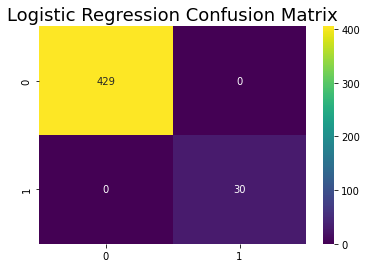

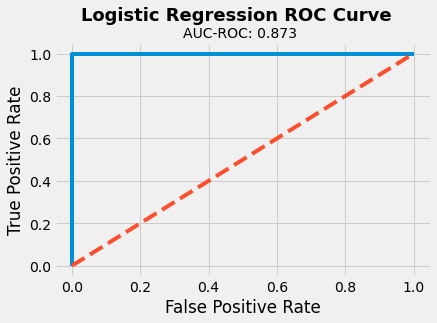

In [16]:
# Evaluating the model
pred_log = evaluate(log_clsf, data_pca)


pred_log['mvp_winner'] = pred_log['mvp_pred_rank']
pred_log['mvp_winner'].loc[pred_log['mvp_winner'] != 1] = 0


# The accuracy of the MVP predictions (how many MVP were predicted correclty and not the total ammount of corect predictions for both classes)
#print("MVPs prediction accuracy: ", round((len(pred_log[(pred_log['MVP'] == 1) & (pred_log['mvp_pred_rank'] == 1)]) / len(pred_log[pred_log['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_log['MVP']
y_pred = pred_log['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))
log_accuracy = accuracy_score(ytest, y_pred)

log_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % log_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))
# The ROC score
propabilities = pred_log['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('Logistic Regression Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.873 ",  fontsize = 14)
roc.suptitle("Logistic Regression ROC Curve", weight = 'bold', y = 1.007, size = 18)


## Linear Discriminant Analysis

MVPs prediction accuracy:  100.0 % 

The model's predictions:
 True Positives: 429 
 False Positives:  0 
 False Negatives:  0 
 True Positives:  30 

The metrics:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Area under ROC curve: 1.000 



Text(0.5, 1.007, 'LDA ROC Curve')

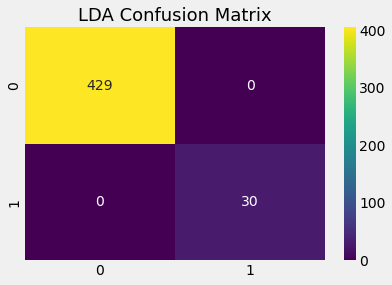

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


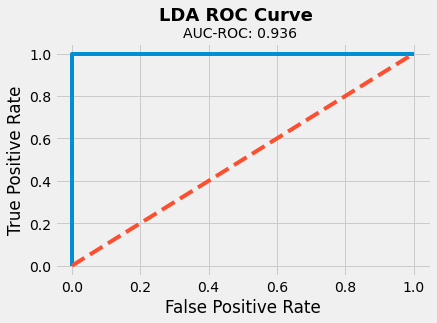

In [17]:
# Evaluating the model
pred_lda = evaluate(lda_clsf, data_pca)

# We are going to assign a class to all predictions to help us evaluate our model
# Winners for each season are defined by the highest propability. They are classified with the minority class 1 and all the others are classified with the majority class 0

pred_lda['mvp_winner'] = pred_lda['mvp_pred_rank']
pred_lda['mvp_winner'].loc[pred_lda['mvp_winner'] != 1] = 0

# The accuracy of the MVP predictions (what percentage of players that our model predicted would win actually did)
print("MVPs prediction accuracy: ", round((len(pred_lda[(pred_lda['MVP'] == 1) & (pred_lda['mvp_pred_rank'] == 1)]) / len(pred_lda[pred_lda['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_lda['MVP']
y_pred = pred_lda['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))
#lda_accuracy = accuracy_score(ytest, y_pred)

lda_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % lda_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))

# The ROC score
propabilities = pred_lda['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('LDA Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.936 ", fontname = 'Calibri', fontsize = 14)
roc.suptitle("LDA ROC Curve", weight = 'bold', y = 1.007, size = 18)


## Support Vector Machines

The model's predictions:
 True Positives: 429 
 False Positives:  0 
 False Negatives:  0 
 True Positives:  30 

The metrics:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Area under ROC curve: 1.000 



Text(0.5, 1.007, 'SVC ROC Curve')

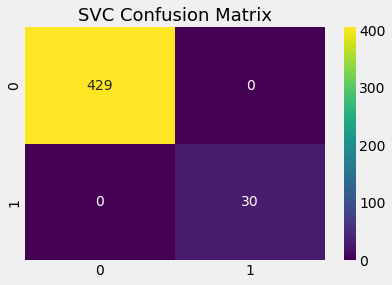

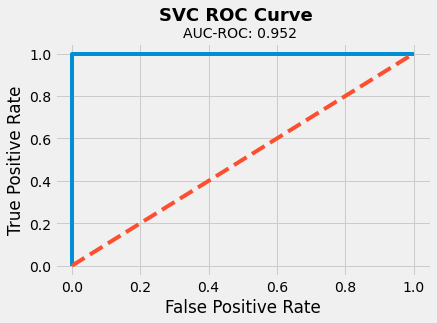

In [18]:
# Evaluating the model
pred_svc = evaluate(svc_clsf, data_pca)

# We are going to assign a class to all predictions to help us evaluate our model
# Winners for each season are defined by the highest propability. They are classified with the minority class 1 and all the others are classified with the majority class 0

pred_svc['mvp_winner'] = pred_svc['mvp_pred_rank']
pred_svc['mvp_winner'].loc[pred_svc['mvp_winner'] != 1] = 0

# The accuracy of the MVP predictions (what percentage of players that our model predicted would win actually did)
#print("MVPs prediction accuracy: ", round((len(pred_svc[(pred_svc['MVP'] == 1) & (pred_svc['mvp_pred_rank'] == 1)]) / len(pred_svc[pred_svc['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_svc['MVP']
y_pred = pred_svc['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))
svc_accuracy = accuracy_score(ytest, y_pred)

svc_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % svc_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))

# The ROC score
propabilities = pred_svc['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('SVC Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.952 ", fontname = 'Calibri', fontsize = 14)
roc.suptitle("SVC ROC Curve", weight = 'bold', y = 1.007, size = 18)


## Naive Bayes classifier

The model's predictions:
 True Positives: 429 
 False Positives:  0 
 False Negatives:  0 
 True Positives:  30 

The metrics:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Area under ROC curve: 1.000 



Text(0.5, 1.007, 'Naive Bayes ROC Curve')

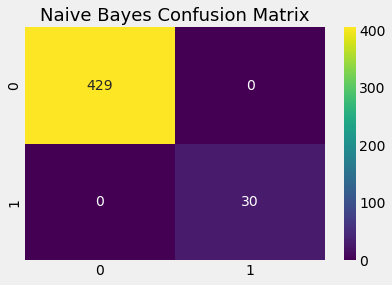

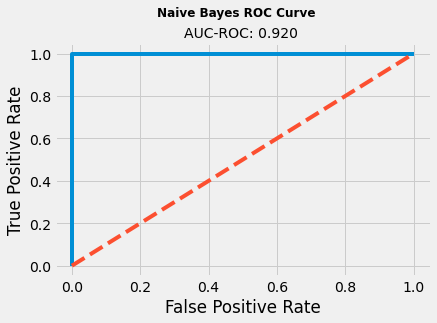

In [19]:
# Evaluating the model
pred_bayes = evaluate(bayes_clsf, data_pca)

# We are going to assign a class to all predictions to help us evaluate our model
# Winners for each season are defined by the highest propability. They are classified with the minority class 1 and all the others are classified with the majority class 0

pred_bayes['mvp_winner'] = pred_bayes['mvp_pred_rank']
pred_bayes['mvp_winner'].loc[pred_bayes['mvp_winner'] != 1] = 0

# The accuracy of the MVP predictions (what percentage of players that our model predicted would win actually did)
#print("MVPs prediction accuracy: ", round((len(pred_bayes[(pred_bayes['MVP'] == 1) & (pred_bayes['mvp_pred_rank'] == 1)]) / len(pred_bayes[pred_bayes['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_bayes['MVP']
y_pred = pred_bayes['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))

bayes_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % bayes_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))
bayes_accuracy = accuracy_score(ytest, y_pred)

# The ROC score
propabilities = pred_bayes['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('Naive Bayes Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.920 ", fontname = 'Calibri', fontsize = 14)
roc.suptitle("Naive Bayes ROC Curve", weight = 'bold', y = 1.007, size = 12)


## decision Tree classification

The model's predictions:
 True Positives: 381 
 False Positives:  48 
 False Negatives:  0 
 True Positives:  30 

The metrics:
Accuracy: 0.895
Recall: 1.000
Precision: 0.385
F1: 0.556
Area under ROC curve: 0.949 



Text(0.5, 1.007, 'Decision Tree ROC Curve')

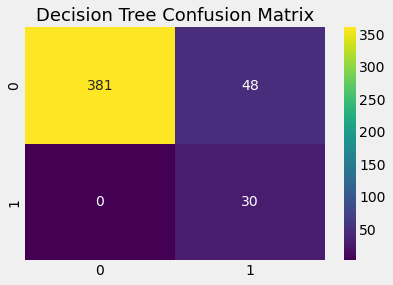

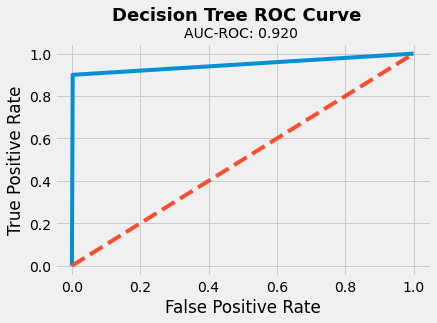

In [20]:
# Evaluating the model
pred_dt = evaluate(dt_clsf, data_pca)

# We are going to assign a class to all predictions to help us evaluate our model
# Winners for each season are defined by the highest propability. They are classified with the minority class 1 and all the others are classified with the majority class 0

pred_dt['mvp_winner'] = pred_dt['mvp_pred_rank']
pred_dt['mvp_winner'].loc[pred_dt['mvp_winner'] != 1] = 0

# The accuracy of the MVP predictions (what percentage of players that our model predicted would win actually did)
#print("MVPs prediction accuracy: ", round((len(pred_dt[(pred_dt['MVP'] == 1) & (pred_dt['mvp_pred_rank'] == 1)]) / len(pred_dt[pred_dt['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_dt['MVP']
y_pred = pred_dt['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))
dt_accuracy = accuracy_score(ytest, y_pred)

dt_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % dt_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))

# The ROC score
propabilities = pred_dt['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('Decision Tree Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.920 ", fontsize = 14)
roc.suptitle("Decision Tree ROC Curve", weight = 'bold', y = 1.007, size = 18)


## KNN classification

The model's predictions:
 True Positives: 429 
 False Positives:  0 
 False Negatives:  0 
 True Positives:  30 

The metrics:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1: 1.000
Area under ROC curve: 1.000 



Text(0.5, 1.007, 'KNN ROC Curve')

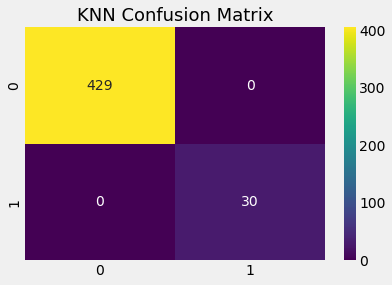

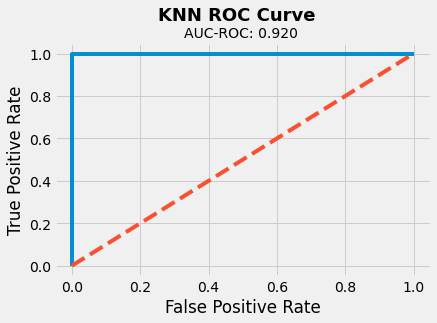

In [21]:
# Evaluating the model
pred_knn = evaluate(knn_clsf, data_pca)

# We are going to assign a class to all predictions to help us evaluate our model
# Winners for each season are defined by the highest propability. They are classified with the minority class 1 and all the others are classified with the majority class 0

pred_knn['mvp_winner'] = pred_knn['mvp_pred_rank']
pred_knn['mvp_winner'].loc[pred_knn['mvp_winner'] != 1] = 0

# The accuracy of the MVP predictions (what percentage of players that our model predicted would win actually did)
#print("MVPs prediction accuracy: ", round((len(pred_knn[(pred_knn['MVP'] == 1) & (pred_knn['mvp_pred_rank'] == 1)]) / len(pred_knn[pred_knn['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_knn['MVP']
y_pred = pred_knn['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))
knn_accuracy = accuracy_score(ytest, y_pred)
knn_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % knn_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))

# The ROC score
propabilities = pred_knn['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('KNN Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.920 ", fontsize = 14)
roc.suptitle("KNN ROC Curve", weight = 'bold', y = 1.007, size = 18)

### Part3: Plotting Accuracy of Models

In [22]:
classification_report = pd.DataFrame()
classification_report = classification_report.append(model_report(log_accuracy, name='Logistic Regression'))
classification_report = classification_report.append(model_report(svc_accuracy, name='SVM'))
classification_report = classification_report.append(model_report(dt_accuracy, name='Decision Tree'))
classification_report = classification_report.append(model_report(knn_accuracy, name='KNN'))
classification_report = classification_report.append(model_report(lda_accuracy, name='LDA'))
classification_report = classification_report.append(model_report(bayes_accuracy, name='Naive Bayes'))


classification_report= classification_report.rename(columns={0:'Accuracy'})
classification_report.sort_values(by='Accuracy', ascending=False)
classification_report.columns
classification_report.Accuracy = 100*classification_report.Accuracy
classification_report

NameError: name 'lda_accuracy' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


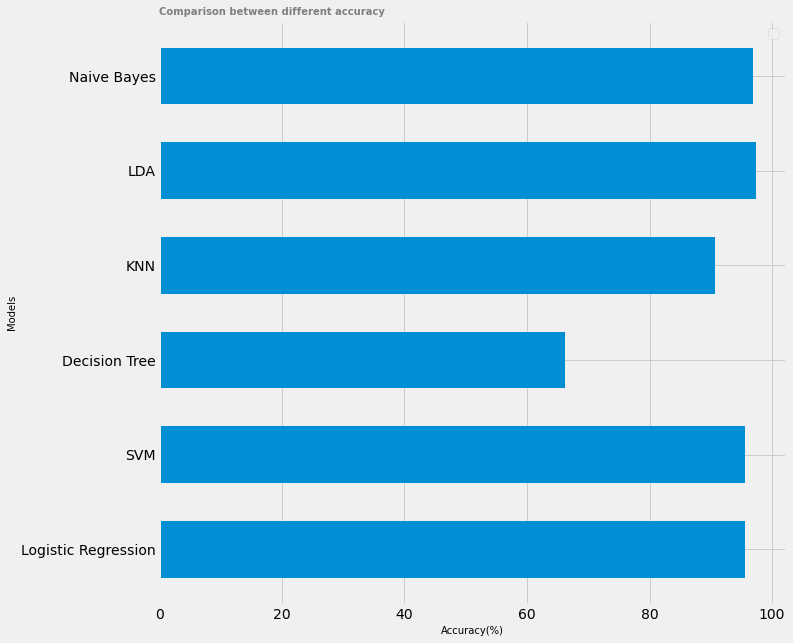

In [ ]:
from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))


plt.figure(figsize=(10,10))

plt.barh(y = classification_report.index,width = classification_report['Accuracy'],height=0.6)
plt.xlabel('Accuracy(%)', fontsize= 10)
plt.ylabel('Models', fontsize= 10)
plt.title('Comparison between different accuracy', fontweight ='bold', fontsize= 10, color="gray", loc='left')
plt.legend()
plt.show()

## Part 4

MVPs prediction accuracy:  73.33 % 

The model's predictions:
 True Positives: 421 
 False Positives:  8 
 False Negatives:  8 
 True Positives:  22 

The metrics:
Accuracy: 0.965
Recall: 0.733
Precision: 0.733
F1: 0.733
Area under ROC curve: 0.973 



Text(0.5, 1.007, 'Clasifiers Ensemble ROC Curve')

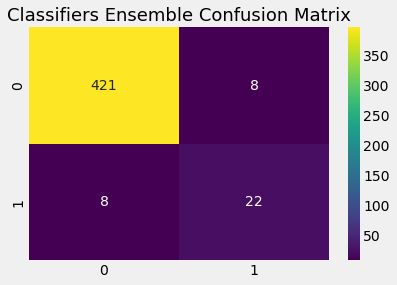

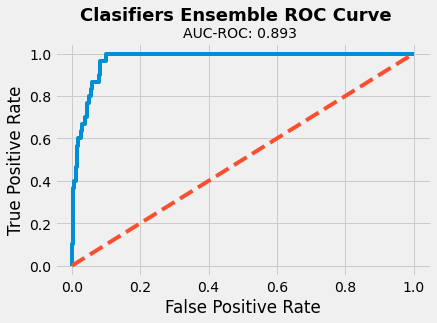

In [ ]:


# get a stacking ensemble of models
# We will use as base 4
def classification_ensemble():
    '''
    A function to create a stucking ensemble of specific algorithms 
    '''
    # define the base models
    level0 = list()
    level0.append(('Bayes', bayes_clsf))
    level0.append(('log', log_clsf))
    level0.append(('LDA', lda_clsf))   
    level0.append(('SVC', svc_clsf))       
    # define meta learner model
    level1 = log_clsf
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

ensemble_clsf = classification_ensemble()




# Evaluating the model
pred_ensemble = evaluate(ensemble_clsf, data_pca)

# We are going to assign a class to all predictions to help us evaluate our model
# Winners for each season are defined by the highest propability. They are classified with the minority class 1 and all the others are classified with the majority class 0

pred_ensemble['mvp_winner'] = pred_ensemble['mvp_pred_rank']
pred_ensemble['mvp_winner'].loc[pred_ensemble['mvp_winner'] != 1] = 0

# The accuracy of the MVP predictions (what percentage of players that our model predicted would win actually did)
print("MVPs prediction accuracy: ", round((len(pred_ensemble[(pred_ensemble['MVP'] == 1) & (pred_ensemble['mvp_pred_rank'] == 1)]) / len(pred_ensemble[pred_ensemble['MVP'] == 1]))*100 , 2), '%', '\n')

# calculate model metrics
ytest = pred_ensemble['MVP']
y_pred = pred_ensemble['mvp_winner']

# The Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("The model's predictions:\n" ,
      'True Positives:' , tn, '\n',
      'False Positives: ', fp, '\n',
      'False Negatives: ' , fn, '\n',
      'True Positives: ' , tp, '\n')

# The metrics
print("The metrics:")
print("Accuracy: %.3f" % accuracy_score(ytest, y_pred))
print("Recall: %.3f" % recall_score(ytest, y_pred))

ensemble_preci = precision_score(ytest, y_pred)
print("Precision: %.3f" % ensemble_preci)
print("F1: %.3f" % f1_score(ytest, y_pred))

# The ROC score
propabilities = pred_ensemble['mvp_propability'].values
ROC_score = roc_auc_score(ytest, propabilities)
print("Area under ROC curve: %.3f" % ROC_score, '\n')

# Ploting the confusion matrix for a better visualization of the model performance metrics
sns.heatmap(cm, annot=True, robust=True, cmap="viridis", fmt='g')
plt.title('Classifiers Ensemble Confusion Matrix', fontsize = 18)

# Ploting the ROC curve and the Area Under the ROC curve
plt.style.use('fivethirtyeight')
roc, ax = plt.subplots()

fpr, tpr, _ = roc_curve(ytest, propabilities)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], linestyle = '--')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("AUC-ROC: 0.893 ", fontname = 'Calibri', fontsize = 14)
roc.suptitle("Clasifiers Ensemble ROC Curve", weight = 'bold', y = 1.007, size = 18)